In [1]:
import os
import json
import random

from pathlib import Path
from glob import glob
from collections import defaultdict
from tqdm import tqdm

from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
import pprint

import numpy as np
import json
import pickle

In [2]:
os.environ["MKL_NUM_THREADS"] = "3" 
os.environ["NUMEXPR_NUM_THREADS"] = "3" 
os.environ["OMP_NUM_THREADS"] = "3"

In [3]:
root = Path('/data3/datasets/kepco_ai_hub/train/images')

phase = os.listdir(root)
print(phase)

phase1 = sorted(os.listdir(root / phase[1]))    # 변전소
print(phase1)

phase2 = sorted(os.listdir(root / phase[1] / phase1[1]))    # 계기용변성기(MOF)
print(phase2[:10])

# 위치/부품/규격/촬영일시/프레임번호/화상정보/정상or위험.jpg
# 02(변전소) / 02(계기용변성기(MOF)) / 01(규격) / 0730(촬영일시) / (1518)(프레임번호) / (0001)(화상정보) / 0101 -> lwir, 0201-> rgb, 0301 -> resized rgb
print(root / phase[1] / phase1[1] / phase2[1])

['1.서부발전', '2.변전소', '3.쓰레기소각장', '4.철도차량']
['1.단로기(DS)', '2.계기용변성기(MOF)', '3.변압기 케이블 연결개소 포함', '4.계기용변압기(PT)', '5.계기용변류기(CT)', '6.전자접촉기', '7.케이블&부스 연결개소']
['0202010730(1518)(0001)0101.csv', '0202010730(1518)(0001)0101.jpg', '0202010730(1518)(0001)0201.jpg', '0202010730(1518)(0001)0301.jpg', '0202010730(1518)(0002)0101.csv', '0202010730(1518)(0002)0101.jpg', '0202010730(1518)(0002)0201.jpg', '0202010730(1518)(0002)0301.jpg', '0202010730(1518)(0003)0101.csv', '0202010730(1518)(0003)0101.jpg']
/data3/datasets/kepco_ai_hub/train/images/2.변전소/2.계기용변성기(MOF)/0202010730(1518)(0001)0101.jpg


##### _**Visualization**_

In [4]:
import csv
import itertools

csvfile = open(root / Path('2.변전소/2.계기용변성기(MOF)/0202010730(1518)(0001)0101.csv'), 'r')
rdr = list(csv.reader(csvfile))

# 방사율; 열 반사; 촬영 거리; 대기 온도; 상대 습도
print(list(itertools.chain.from_iterable(rdr[:5])))

csvfile.close()

['Emissivity;0.95', 'ReflectedTemperature;24.00', 'Distance;1.0', 'AtmosphericTemperature;24.00', 'RelativeHumidity;50.00']


h: 512, w: 640


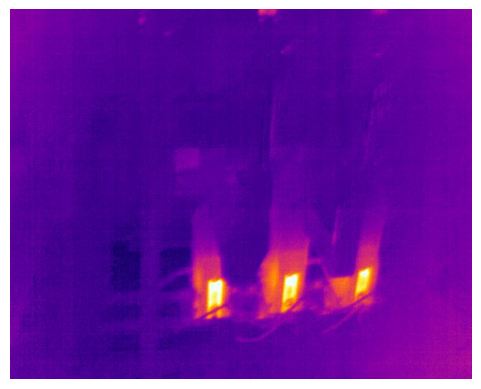

In [5]:
lwir_path = root / Path('2.변전소/2.계기용변성기(MOF)/0202010730(1518)(0001)0101.jpg')
lwir = cv2.imread(str(lwir_path))
lwir = cv2.cvtColor(lwir, cv2.COLOR_BGR2RGB)

print(f'h: {lwir.shape[0]}, w: {lwir.shape[1]}')

plt.axis('off')
plt.imshow(lwir)

# Save image w/o white border
# plt.savefig('lwir.png', bbox_inches='tight', pad_inches=0)

h: 1080, w: 1920


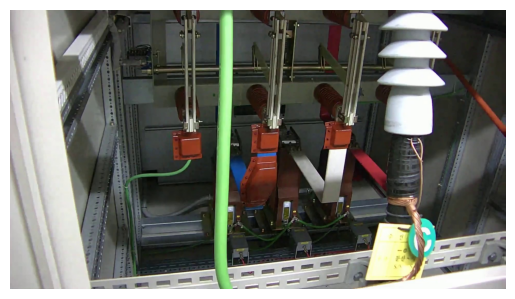

In [6]:
ori_rgb_path = root / Path('2.변전소/2.계기용변성기(MOF)/0202010730(1518)(0001)0201.jpg')
ori_rgb = cv2.imread(str(ori_rgb_path))
ori_rgb = cv2.cvtColor(ori_rgb, cv2.COLOR_BGR2RGB)

print(f'h: {ori_rgb.shape[0]}, w: {ori_rgb.shape[1]}')

plt.axis('off')
plt.imshow(ori_rgb)

h: 993, w: 1530


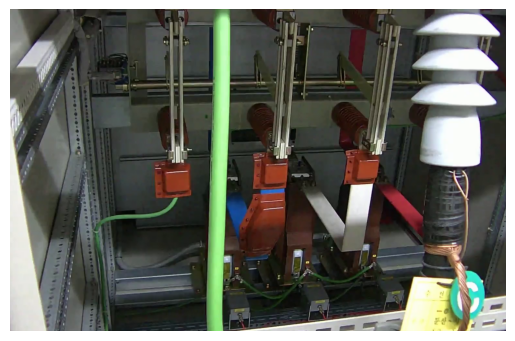

In [7]:
rgb_path = root / Path('2.변전소/2.계기용변성기(MOF)/0202010730(1518)(0001)0301.jpg')
rgb = cv2.imread(str(rgb_path))
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

print(f'h: {rgb.shape[0]}, w: {rgb.shape[1]}')

plt.axis('off')
plt.imshow(rgb)

##### _**Annotation**_

In [8]:
root = Path('/data3/datasets/kepco_ai_hub/train/labels/')

def read_annotation(anno_path):
    with open(anno_path) as f:
        try:
            annotation = json.load(f)
            # pprint.pprint(annotation)
        except json.decoder.JSONDecodeError:
            print('The string dose NOT contain valid JSON')
    
    return annotation

In [9]:
read_annotation('/data3/datasets/kepco_ai_hub/train/labels/1.서부발전/1.고압전동기/0101011116(1023)(0008)0101.json')

{'image': {'filename': '0101011116(1023)(0008)0101.jpg',
  'filename_rgb': '0101011116(1023)(0008)0301.jpg'},
 'csv': {'filename_csv': '0101011116(1023)(0008)0101.csv',
  'temp_start': 'A6',
  'delimiter': ';'},
 'metadata': {'date_created': '2021.12.10. 18:53',
  'type': 'JPG',
  'width': 640,
  'height': 512,
  'aspect_ratio': '5:4',
  'region_name': '서부발전',
  'facility_id': '01',
  'facility': '고압전동기',
  'camera_height': '2m',
  'camera_angle': 32.12,
  'status': 'normal',
  'emissivity': 0.95,
  'obj_distance': 2.0,
  'reflected_temp': 20.0,
  'atmospheric_temp': 20.0,
  'relative_humidity': 40.0},
 'annotations': [{'id': 'VAj8xsQH2hn-fhTfVpV_G',
   'category': 'bounding_box',
   'class': '고압전동기',
   'attributes': {'status': 'normal', 'standard': '2400kW'},
   'data': {'x': 464, 'y': 365, 'width': 18, 'height': 77}}]}

##### _**Set file path**_

In [10]:
images = 'images'
labels = 'labels'

root = Path('/data3/datasets/kepco_ai_hub/train/')

region = os.listdir(root / images)[:2]

In [11]:
# facility dict with full path
facilities_path = defaultdict(list)
for region_ in region:
    pbar = tqdm(sorted(os.listdir(root / images / region_)))
    for facility_ in pbar:
        if facility_ == '5.계기용변류기(CT)':
            continue
        pbar.set_description(f'Process on {region_}')
        
        for fpath in sorted(Path(root / images / Path(region_) / Path(facility_)).glob('./*.jpg')):
            facilities_path[region_ + '/' + facility_].append(fpath.absolute())
            
facilities = facilities_path.keys()

Process on 2.변전소: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


In [12]:
# annotation dict with full path
annotations = defaultdict(list)
len_facilities = list()

for facility_ in facilities:
    for fpath in sorted(Path(root / labels / Path(facility_)).glob('./*.json')):
        annotations[facility_].append(fpath.absolute())
        
    len_facilities.append(len(annotations[facility_]))
    print(f'Number of images, {facility_} : {len(annotations[facility_])}')

Number of images, 1.서부발전/1.고압전동기 : 36329
Number of images, 1.서부발전/2.차단기 : 27145
Number of images, 1.서부발전/3.변압기 접속부 : 27046
Number of images, 2.변전소/1.단로기(DS) : 25003
Number of images, 2.변전소/2.계기용변성기(MOF) : 13585
Number of images, 2.변전소/3.변압기 케이블 연결개소 포함 : 34156
Number of images, 2.변전소/4.계기용변압기(PT) : 23804
Number of images, 2.변전소/6.전자접촉기 : 16670
Number of images, 2.변전소/7.케이블&부스 연결개소 : 25640


In [13]:
places = {
    '1.서부발전':
        {
        '1.고압전동기',
        '2.차단기',
        '3.변압기 접속부'
        },
    '2.변전소':
        {
        '1.단로기(DS)', 
        '2.계기용변성기(MOF)', 
        '3.변압기 케이블 연결개소 포함', 
        '4.계기용변압기(PT)', 
        '6.전자접촉기', 
        '7.케이블&부스 연결개소'
        },
    }

##### _**Split RGB / LWIR**_

In [14]:
sep = ['01', '02', '03'] # LWIR / ori RGB / RGB
RGB_LWIR_sep = defaultdict(list)

pbar = tqdm(list(sorted(facilities)))
for facility_ in pbar:
    pbar.set_description(f'Process on {facility_}')

    for path in facilities_path[facility_]:
        # Split LWIR
        if path.stem.split(')')[-1].startswith(sep[0]):
            RGB_LWIR_sep[facility_ + '/lwir'].append(path)
            
        # Split Original RGB
        elif path.stem.split(')')[-1].startswith(sep[1]):
            RGB_LWIR_sep[facility_ + '/ori_rgb'].append(path)
        
        # Split RGB
        elif path.stem.split(')')[-1].startswith(sep[2]):
            RGB_LWIR_sep[facility_ + '/rgb'].append(path)

Process on 2.변전소/7.케이블&부스 연결개소: 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]          


In [15]:
lwir_keys, orirgb_keys, rgb_keys, anno_keys = list(), list(), list(), list()

for sep in list(RGB_LWIR_sep.keys()):
    if sep.endswith('lwir'):
        lwir_keys.append(sep)
        anno_keys.append(sep[:-5])
    elif sep.endswith('ori_rgb'):
        orirgb_keys.append(sep)
    elif sep.endswith('rgb'):
        rgb_keys.append(sep)

In [16]:
# List with lwir, orirgb, rgb, annotations
image_anno_pair = list()
for facility_lwir, facility_orirgb, facility_rgb, facility_anno in zip(lwir_keys, orirgb_keys, rgb_keys, anno_keys):
    for lwir_path, orirgb_path, rgb_path, anno_path in zip(RGB_LWIR_sep[facility_lwir], RGB_LWIR_sep[facility_orirgb], RGB_LWIR_sep[facility_rgb], annotations[facility_anno]):
        image_anno_pair.append([str(lwir_path), str(orirgb_path), str(rgb_path), str(anno_path)])

##### _**Draw bounding box on image**_

In [17]:
def read_pair(lwir_path, rgb_path, annotation_path):
    lwir = cv2.imread(lwir_path)
    lwir = cv2.cvtColor(lwir, cv2.COLOR_BGR2RGB)

    rgb = cv2.imread(rgb_path)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, dsize=(lwir.shape[1], lwir.shape[0]), interpolation=cv2.INTER_AREA)
    
    annotation = read_annotation(annotation_path)
    
    return lwir, rgb, annotation 

In [18]:
def draw_bbox(image, annotation):
    img = Image.fromarray(image.astype(np.uint8))
    draw = ImageDraw.Draw(img)
    
    font_path = './gulim.ttc'
    font_size = 15
    font = ImageFont.truetype(font_path, font_size)
    
    meta_db = annotation['metadata']
    
    # image information (region, facility, created date, camera angle, reflected temperature)
    region = meta_db['region_name'] + '/' + meta_db['facility']
    uni_region = region.encode('utf-8').decode('utf-8')
    draw.text(((meta_db['width'] - font.getlength(uni_region)) // 2, 5), uni_region, font=font)
    
    info = meta_db['date_created'].split(' ')[-1] + ' ' + str(meta_db['camera_angle']) + ' ' + str(meta_db['reflected_temp'])
    utf8_info = info.encode('utf-8')
    draw.text(((meta_db['width'] - font.getlength(uni_region)) // 2 + 20, 25), utf8_info)
    
    for data_db in annotation['annotations']:
        # bbox offset
        bbox = data_db['data']
        x2 = bbox['x'] + bbox['width']
        y2 = bbox['y'] + bbox['height']
        
        status = data_db['attributes']['status']      
        offset = '(' + str(bbox['height']) + ',' + str(bbox['width']) + ')'
        # normal: outline color: Green
        if status == 'normal':
            draw.rectangle((bbox['x'], bbox['y'], x2, y2),
                            outline='green', 
                            width=5)   
            draw.text((bbox['x'] + bbox['width'] // 2 - font.getlength(status) // 2, bbox['y'] - 20), status)
            draw.text((bbox['x'] + bbox['width'] // 2 - font.getlength(offset) // 2, bbox['y'] - 10), offset)
        
        # danger: outline color: Red
        elif status == 'danger':
            draw.rectangle((bbox['x'], bbox['y'], x2, y2),
                            outline='red', 
                            width=5)
            draw.text((bbox['x'] + bbox['width'] // 2 - font.getlength(status) // 2, bbox['y'] - 20), status)
            draw.text((bbox['x'] + bbox['width'] // 2 - font.getlength(offset) // 2, bbox['y'] - 10), offset)
        else:
            raise ValueError
        
    return img

In [19]:
def triple_image(lwir_path, rgb_path, annotation_path, alpha=0.6):
    lwir, rgb, annotation = read_pair(lwir_path, rgb_path, annotation_path)
    
    blend = np.array(lwir) * alpha + np.array(rgb) * (1-alpha)
    
    lwir_bbox = draw_bbox(lwir, annotation)
    rgb_bbox = draw_bbox(rgb, annotation)
    blend_bbox = draw_bbox(blend, annotation)
    
    return [lwir_bbox, rgb_bbox, blend_bbox]

In [20]:
# image_anno_pair to pickle
all_path = '../../json/all.json'
with open(all_path, 'w+') as f:
    json.dump(image_anno_pair, f, ensure_ascii=False, indent=4)

In [21]:
normal_path = '../../json/normal_case.json'

with open(normal_path, 'r') as f:
    normal_case = json.load(f)

In [26]:
abnormal_path = '../../json/abnormal_case.json'

with open(abnormal_path, 'r') as f:
    abnormal_case = json.load(f)

In [27]:
classes = list()
classes.extend(places['1.서부발전'])
classes.extend(places['2.변전소'])

normal_img_anno_per_class = defaultdict(list)

for ano in normal_case:
    for cls in classes:
        if cls in ano:
            fname = ano.rsplit('.', maxsplit=1)[0].rsplit(')', maxsplit=1)[0] + ')'
            lwir = fname + '0101' + '.jpg'
            rgb  = fname + '0301' + '.jpg'
            
            lwir = lwir.replace('labels', 'images')
            rgb  = rgb.replace('labels', 'images')
            normal_img_anno_per_class[cls].append([lwir, rgb, ano])
            
abnormal_img_anno_per_class = defaultdict(list)

for ano in abnormal_case:
    for cls in classes:
        if cls in ano:
            fname = ano.rsplit('.', maxsplit=1)[0].rsplit(')', maxsplit=1)[0] + ')'
            lwir = fname + '0102' + '.jpg'
            rgb  = fname + '0302' + '.jpg'

            lwir = lwir.replace('labels', 'images')
            rgb  = rgb.replace('labels', 'images')
            
            abnormal_img_anno_per_class[cls].append([lwir, rgb, ano])

In [69]:
num_images = 3

images = defaultdict(list)

for cls in classes:
    numbers = random.sample(range(0, len(normal_img_anno_per_class[cls]) + 1), num_images)
    for num in numbers:
        lwir_path, rgb_path, annotation_path = normal_img_anno_per_class[cls][num]
        lwir, rgb, blend = triple_image(lwir_path, rgb_path, annotation_path)
        ori_lwir = Image.open(lwir_path).convert('RGB')
        ori_rgb  = Image.open(rgb_path).convert('RGB')
        images[cls].append([ori_lwir, ori_rgb, lwir, rgb, blend])

In [78]:
num_images = 3

images_abnormal = defaultdict(list)

for cls in classes:
    numbers = random.sample(range(0, len(abnormal_img_anno_per_class[cls]) + 1), num_images)
    for num in numbers:
        lwir_path, rgb_path, annotation_path = abnormal_img_anno_per_class[cls][num]
        lwir, rgb, blend = triple_image(lwir_path, rgb_path, annotation_path)
        ori_lwir = Image.open(lwir_path).convert('RGB')
        ori_rgb  = Image.open(rgb_path).convert('RGB')
        images_abnormal[cls].append([ori_lwir, ori_rgb, lwir, rgb, blend])

In [79]:
IMAGE_PATH = '/home/silee/workspace/capstone/images'

for cls in classes:
    for i, (ori_lwir, ori_rgb, lwir, rgb, blend) in enumerate(images[cls]):
        ori_lwir.save(f"{IMAGE_PATH}/{cls}/origin_lwir/{i}.jpg")
        ori_rgb.save(f"{IMAGE_PATH}/{cls}/origin_rgb/{i}.jpg")
        lwir.save(f"{IMAGE_PATH}/{cls}/lwir/{i}.jpg")
        rgb.save(f"{IMAGE_PATH}/{cls}/rgb/{i}.jpg")
        blend.save(f"{IMAGE_PATH}/{cls}/blend/{i}.jpg")

In [80]:
IMAGE_PATH = '/home/silee/workspace/capstone/images'

for cls in classes:
    for i, (ori_lwir, ori_rgb, lwir, rgb, blend) in enumerate(images_abnormal[cls], start=3):
        ori_lwir.save(f"{IMAGE_PATH}/{cls}/origin_lwir/{i}.jpg")
        ori_rgb.save(f"{IMAGE_PATH}/{cls}/origin_rgb/{i}.jpg")
        lwir.save(f"{IMAGE_PATH}/{cls}/lwir/{i}.jpg")
        rgb.save(f"{IMAGE_PATH}/{cls}/rgb/{i}.jpg")
        blend.save(f"{IMAGE_PATH}/{cls}/blend/{i}.jpg")